In [1]:
from backpack_predictor import prepare_data, target_encoding
from backpack_predictor.features import target, baseline_features, feature_list, cat_cols

%load_ext autoreload
%autoreload 2

from datetime import datetime
import time
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer, TargetEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import root_mean_squared_error

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

test_df = pd.read_csv(r'..//data//test.csv')
train_df = pd.read_csv(r'..//data//train.csv')
train_extra_df = pd.read_csv(r'..//data//training_extra.csv')
train_df = pd.concat([train_df, train_extra_df], ignore_index=True)

# cat_features = []
# train_df[cat_features] = train_df[cat_features].astype('category')
# test_df[cat_features] = test_df[cat_features].astype('category')

train_df = prepare_data(train_df, is_train=True)
test_df = prepare_data(test_df, is_train=False)

In [2]:
train_df

,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,price
0,3,0,1,7,1,0,2,0,11.611723,112.15875
1,3,3,0,10,1,1,1,4,27.078537,68.88056
2,4,0,0,2,1,0,1,2,16.643760,39.17320
3,2,1,0,8,1,0,1,4,12.937220,80.60793
4,0,3,1,1,1,1,1,4,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...
3994313,2,3,-1,3,1,1,1,5,28.098120,104.74460
3994314,1,0,0,10,1,1,2,5,17.379531,122.39043
3994315,3,3,2,10,0,0,0,2,17.037708,148.18470
3994316,1,3,-1,2,0,0,0,1,28.783339,22.32269


In [3]:
# col1 = 'brand'
col1 = 'material'
col2 = 'is_waterproof'
stats = ['mean', 'skew', 'var', 'count']

agg_stats = train_df.groupby(col1)[col2].agg(stats)
agg_stats

,mean,skew,var,count
material,,,,
-1,0.482679,-0.208553,0.276631,110962
0,0.470462,-0.320208,0.296113,976186
1,0.468796,-0.316200,0.296348,942656
2,0.468634,-0.333528,0.298894,1060882
3,0.468095,-0.309644,0.295763,903632


In [ ]:
c1 = 'laptop_compartment'
c2 = 'is_waterproof'

In [8]:
train_df.laptop_compartment.unique()

array([ 1,  0, -1])

In [7]:
train_df.material.unique()

array([ 0,  3,  1, -1,  2])

In [ ]:
    train_df[n] = train_df[c2]*100 + train_df[c2]


In [ ]:
CATS = ['laptop_compartment', 'is_waterproof', 'material', 'brand',]
COMBO = []
for i, c in enumerate(CATS):
    combine = pd.concat([train_df[c], test_df[c]],axis=0)
    combine, _ = pd.factorize(combine)
    train_df[c] = combine[:len(train_df)]
    test_df[c] = combine[len(train_df):]
    n = f"{c}_wc"
    train_df[n] = train_df[c]*100 + train_df["Weight Capacity (kg)"]
    test_df[n] = test_df[c]*100 + test_df["Weight Capacity (kg)"]
    COMBO.append(n)
print()
print(f"We engineer {len(COMBO)} new columns!")
print( COMBO )

In [25]:
import itertools


def create_numeric_comb_features(train_df, test_df, cols, comb_size, allowed_features=None, base=100):
    """
    Creates numeric combination features for all valid combinations of the given columns
    in a vectorized fashion.

    For each combination of columns, we compute a new feature as follows (example for 3 columns):
      new_val = ((col1 * base + col2) * base) + col3
    
    Args:
        train_df (pd.DataFrame): Training dataframe
        test_df  (pd.DataFrame): Test dataframe
        cols (list of str): List of columns to combine
        allowed_features (set or list of str): Names of combination columns you want to allow
        comb_size (int): Size of the combination (e.g. 2 for pairs, 3 for triplets, etc.)
        base (int): Base multiplier used to produce numeric encodings
    """
    new_cols = []
    for comb in itertools.combinations(cols, comb_size):
        # Create a name like "num_c1_c2" from columns c1, c2
        col_name = f"num_{'_'.join(comb)}"
        
        if allowed_features and col_name not in allowed_features:
                continue

        # --- Vectorized combination for the TRAIN set ---
        # Start with the first column's values
        comb_series = train_df[comb[0]].astype(int).copy()
        # Iteratively multiply by base and add the next column
        for c in comb[1:]:
            comb_series = comb_series * base + train_df[c].astype(int)
        train_df[col_name] = comb_series
        
        # --- Vectorized combination for the TEST set ---
        comb_series_test = test_df[comb[0]].astype(int).copy()
        for c in comb[1:]:
            comb_series_test = comb_series_test * base + test_df[c].astype(int)
        test_df[col_name] = comb_series_test

        new_cols.append(col_name)

    return new_cols

cols = ['compartments', 'brand', 'material', 'size', 'laptop_compartment', 'is_waterproof', 'style', 'color']
col_comb_2 = create_numeric_comb_features(train_df, test_df, cols, 2)
col_comb_3 = create_numeric_comb_features(train_df, test_df, cols, 3)
col_comb_4 = create_numeric_comb_features(train_df, test_df, cols, 4)
len(col_comb_2 + col_comb_3 + col_comb_4)
# col_comb_3

154

In [26]:
train_df

,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,price,...,num_material_size_style_color,num_material_laptop_compartment_is_waterproof_style,num_material_laptop_compartment_is_waterproof_color,num_material_laptop_compartment_style_color,num_material_is_waterproof_style_color,num_size_laptop_compartment_is_waterproof_style,num_size_laptop_compartment_is_waterproof_color,num_size_laptop_compartment_style_color,num_size_is_waterproof_style_color,num_laptop_compartment_is_waterproof_style_color
0,3,0,1,7,1,0,2,0,11.611723,112.15875,...,10200,10002,10000,10200,200,1010002,1010000,1010200,1000200,1000200
1,3,3,0,10,1,1,1,4,27.078537,68.88056,...,3000104,3010101,3010104,3010104,3010104,10101,10104,10104,10104,1010104
2,4,0,0,2,1,0,1,2,16.643760,39.17320,...,102,10001,10002,10102,102,10001,10002,10102,102,1000102
3,2,1,0,8,1,0,1,4,12.937220,80.60793,...,1000104,1010001,1010004,1010104,1000104,10001,10004,10104,104,1000104
4,0,3,1,1,1,1,1,4,17.749338,86.02312,...,3010104,3010101,3010104,3010104,3010104,1010101,1010104,1010104,1010104,1010104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994313,2,3,-1,3,1,1,1,5,28.098120,104.74460,...,2990105,3010101,3010105,3010105,3010105,-989899,-989895,-989895,-989895,1010105
3994314,1,0,0,10,1,1,2,5,17.379531,122.39043,...,205,10102,10105,10205,10205,10102,10105,10205,10205,1010205
3994315,3,3,2,10,0,0,0,2,17.037708,148.18470,...,3020002,3000000,3000002,3000002,3000002,2000000,2000002,2000002,2000002,2
3994316,1,3,-1,2,0,0,0,1,28.783339,22.32269,...,2990001,3000000,3000001,3000001,3000001,-1000000,-999999,-999999,-999999,1


In [ ]:
# %%time

lgb_params_1 = {'force_col_wise': True, 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'early_stopping_rounds': 916, 'cat_l2': 40.57932515907615, 'extra_trees': False, 'feature_fraction': 0.9028265875188044, 'learning_rate': 0.02133798565133846, 'max_bin': 7449, 'max_depth': 590, 'min_samples_leaf': 22, 'n_estimators': 14706, 'num_leaves': 141, 'lambda_l1': 0.004931837373939155, 'lambda_l2': 2.1647829905701264e-06}

stats = ['mean', 'skew', 'count', 'var']
stats_2 = ['mean', 'skew']
FOLDS = 2

# Target sets use the target variable, and must be trained on the inner CV loop.
target_feature_cols = ['weight_capacity', 'compartments', 'brand', 'color', 'laptop_compartment', 'is_waterproof', 'size', 'material', 'style'] 
target_feature_cols = target_feature_cols 
target_feature_cols_2 = col_comb_2 + col_comb_3 + col_comb_4
target_feature_sets = {
    **{
        f"{col1}": {"stats": stats}
        for col1 in target_feature_cols
    },
    **{
        f"{col2}": {"stats": stats_2}
        for col2 in target_feature_cols_2
    }
}

all_new_cols = []
for col1, v in target_feature_sets.items():
    new_cols = [f"{col1}_{target}_{stat}" for stat in v['stats']]
    target_feature_sets[col1]['new_cols'] = new_cols
    all_new_cols.extend(new_cols)


# feature_sets = {
#     'material': {
#         'col2_list': ['is_waterproof', 'laptop_compartment', 'style', 'size'],
#         'stats': stats,
#     },
# }
feature_sets = {}
additional_features = ['compartments', 'is_waterproof', 'laptop_compartment', 'style', 'material', 'size', 'brand', 'color']
for col1 in additional_features:
    feature_sets[col1] = {
        'col2_list': ['weight_capacity'],
        'stats': stats,
}
for col1, v in feature_sets.items():
    col2_list = v['col2_list']
    new_cols = [f"{col1}_{col2}_{stat}" for col2 in col2_list for stat in stats]
    feature_sets[col1]['new_cols'] = new_cols
    all_new_cols.extend(new_cols)

# features = ['weight_capacity', 'compartments', 'laptop_compartment', 'is_waterproof', 'material', 'brand', 'color', 'size', 'style'] 
features = ['weight_capacity', 'compartments', 'laptop_compartment', 'is_waterproof'] 
features = features + all_new_cols + col_comb_2 + col_comb_3 + col_comb_4
print(f"Using {len(features)} features.")


# Prepare arrays for out-of-fold and test predictions
oof = np.zeros(len(train_df), dtype=float)
pred = np.zeros(len(test_df), dtype=float)

rmse_list = []

kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
for i, (train_idx, valid_idx) in enumerate(kf.split(train_df), 1):
    train_fold = train_df.loc[train_idx].reset_index(drop=True)
    valid_fold = train_df.loc[valid_idx].reset_index(drop=True)

    # -----------------------------------------------------
    # Inner K-Fold (for partial target encoding)
    # -----------------------------------------------------
    kf_inner = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    for j, (inner_train_idx, inner_valid_idx) in enumerate(kf_inner.split(train_fold)):
        inner_train = train_fold.loc[inner_train_idx].copy()
        for col1, v in target_feature_sets.items():
            stats = v['stats']
            new_cols = v['new_cols']
            agg_stats = inner_train.groupby(col1)[target].agg(stats)
            for stat, new_col in zip(stats, new_cols):
                train_fold.loc[inner_valid_idx, new_col] = train_fold.loc[inner_valid_idx, col1].map(agg_stats[stat])

    # -----------------------------------------------------
    # Outer K-Fold Add Feature Sets
    # -----------------------------------------------------
    for col1, v in target_feature_sets.items():
        stats = v['stats']
        new_cols = v['new_cols']
        agg_stats = train_fold.groupby(col1)[target].agg(stats)
        for stat, new_col in zip(stats, new_cols):
            valid_fold.loc[:, new_col] = valid_fold.loc[:, col1].map(agg_stats[stat])
            test_df.loc[:, new_col] = test_df.loc[:, col1].map(agg_stats[stat])

    for col1, v in feature_sets.items():
        stats = v['stats']
        col2_list = v['col2_list']
        new_cols = v['new_cols']
        for k, col2 in enumerate(col2_list):
            agg_stats = train_fold.groupby(col1)[col2].agg(stats)
            for stat, new_col in zip(stats, new_cols[k*len(stats):(k+1)*len(stats)]):
                train_fold.loc[:, new_col] = train_fold.loc[:, col1].map(agg_stats[stat])
                valid_fold.loc[:, new_col] = valid_fold.loc[:, col1].map(agg_stats[stat])
                test_df.loc[:, new_col] = test_df.loc[:, col1].map(agg_stats[stat])

    # -----------------------------------------------------
    # Modeling
    # -----------------------------------------------------
    train_data = lgb.Dataset(train_fold[features], label=train_fold[target])
    valid_data = lgb.Dataset(valid_fold[features], label=valid_fold[target], reference=train_data)
    
    model = lgb.train(
        params=lgb_params_1,
        train_set=train_data,
        valid_sets=[train_data, valid_data],
        valid_names=['train', 'valid'],
    )
    y_pred = model.predict(valid_fold[features], num_iteration=model.best_iteration)
    
    rmse = root_mean_squared_error(valid_fold[target], y_pred)
    rmse_list.append(rmse)
    print(f"[{i}] RMSE: {rmse:.2f},  AVG: {np.mean(rmse_list):.2f}")

    oof[valid_idx] = y_pred
    pred += model.predict(test_df[features], num_iteration=model.best_iteration)

print(f"Mean RMSE: {np.mean(rmse_list):.2f}")

Using 534 features.
[1] RMSE: 38.69,  AVG: 38.69
[2] RMSE: 38.73,  AVG: 38.71
Mean RMSE: 38.71


In [ ]:
df = df.sort_values(by='date')
df['3ma'] = df.groupby('id').rolling(3).mean()


In [ ]:
# Using 268 features.
# [1] RMSE: 38.68,  AVG: 38.68
# [2] RMSE: 38.73,  AVG: 38.71
# Mean RMSE: 38.71

# Using 212 features.
# [1] RMSE: 38.69,  AVG: 38.69
# [2] RMSE: 38.73,  AVG: 38.71
# Mean RMSE: 38.71

# Using 72 features.
# [0] RMSE: 38.72,  AVG: 38.72
# [0] RMSE: 38.76,  AVG: 38.74
# Mean RMSE: 38.74

Note: Change OOF_VERSION

In [27]:
OOF_VERSION = 1
oof_path = f"..//data//oof_v{OOF_VERSION}.csv"
pd.DataFrame(oof).to_csv(oof_path, header=False, index=False)
print("Saving to:", oof_path)

Saving to: ..//data//oof_v1.csv


In [28]:
submit_df = test_df[['id']].copy()
submit_df['Price'] = (pred / FOLDS)
submit_path = f'..//submissions//' + datetime.now().strftime("%Y-%m-%d_%H-%M") + ".csv"
submit_df.to_csv(submit_path, index=False)
print("Saved to:", submit_path)
submit_df.head(5)

Saved to: ..//submissions//2025-02-23_08-27.csv


,id,Price
0,300000,81.538082
1,300001,82.923897
2,300002,88.530664
3,300003,77.294651
4,300004,79.515144


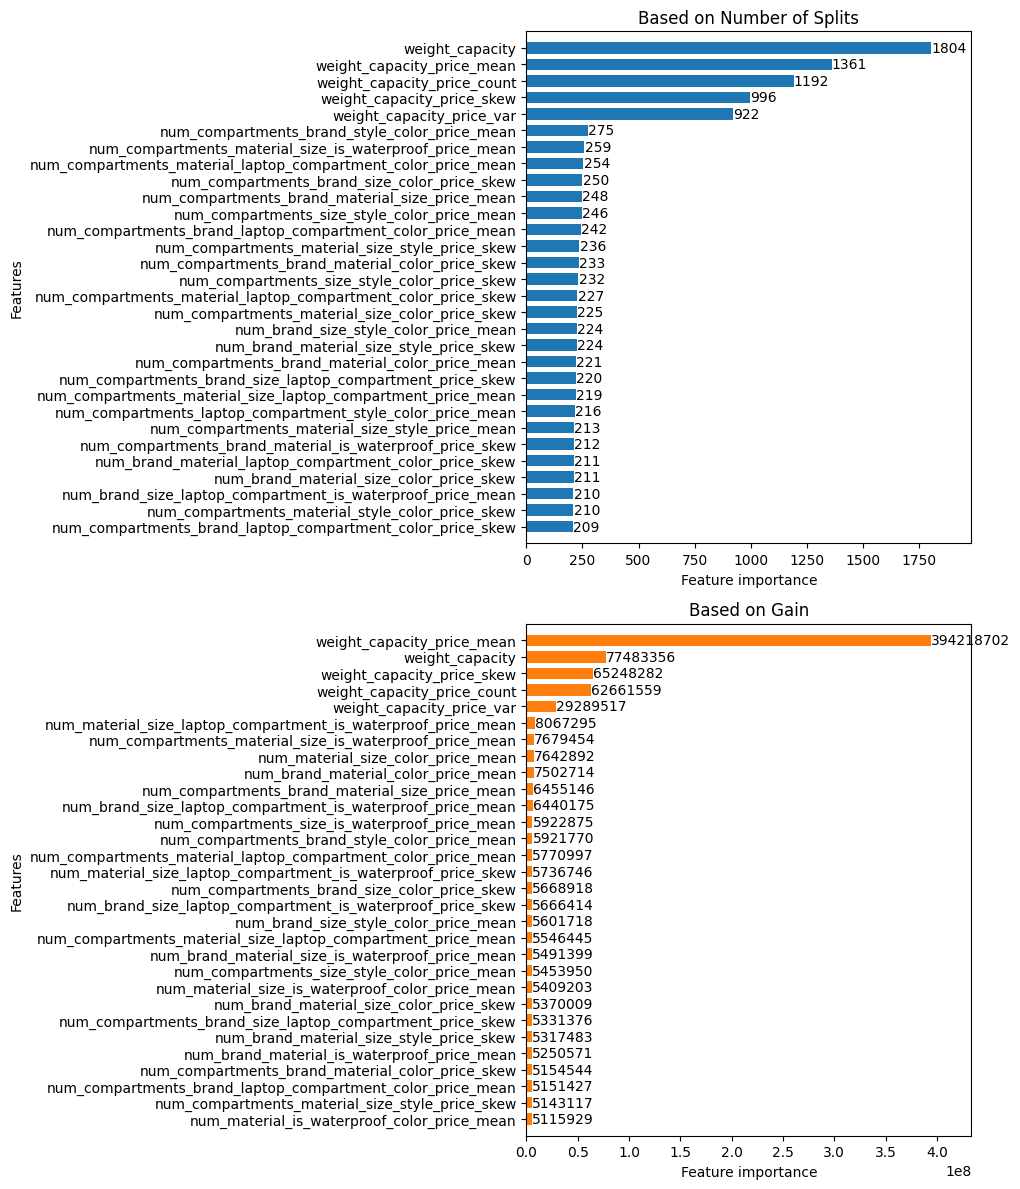

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

lgb.plot_importance(model, ax=axs[0], importance_type='split', max_num_features=30, 
                    height=0.7, grid=False, precision=0, color="tab:blue")
axs[0].set_title("Based on Number of Splits", fontsize=12)

lgb.plot_importance(model, ax=axs[1], importance_type='gain', max_num_features=30, 
                    height=0.7, grid=False, precision=0, color="tab:orange")
axs[1].set_title("Based on Gain", fontsize=12)

plt.tight_layout()
plt.show()